In [11]:
# На датасете lenta-ru-news.csv.bz2 построить классификатор для тем : 
# 'Россия', 'Мир', 'Экономика', 'Спорт', 'Культура' 
import pandas as pd
import numpy as np
import re
import warnings
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn import linear_model
from sklearn.metrics import accuracy_score, f1_score

#Список стоп-слов
import nltk
nltk.download('stopwords')
stop_words = []
stop_words = nltk.corpus.stopwords.words('russian')

# Лемматизатор
import pymorphy2

# Стеммер
from nltk.stem.snowball import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import model_selection, metrics

warnings.filterwarnings('ignore')
#print('The scikit-learn version is {}.'.format(sklearn.__version__))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df = pd.read_csv('lenta-ru-news.csv')

In [ ]:
# оставим в таблице только необходимые рубрики 'Россия', 'Мир', 'Экономика', 'Спорт', 'Культура' 
df = df[df['topic'].isin(['Россия', 'Мир', 'Экономика', 'Спорт', 'Культура'])]

In [14]:
# можно считать рубрики сбалансированными 
df.groupby('topic')['topic'].count() / df.shape[0]

topic
Культура     0.108724
Мир          0.276111
Россия       0.324260
Спорт        0.130179
Экономика    0.160726
Name: topic, dtype: float64

In [ ]:
pd.options.display.max_colwidth = 500
df['text'].head()

In [ ]:
# уберем из текста знаки пунктуации
def delete_punctuation(s):
    return ' '.join((re.sub(r'[№"\'/.:?!1234567890()%<>;,#$&@\s+]', u' ', s)).split())

df['text'] = df['text'].apply(lambda x: delete_punctuation(str(x)))

In [ ]:
# выделяем целевую переменную
def f(x):
    return {
        'Россия': 1,
        'Мир': 2,
        'Экономика' : 3,
        'Спорт' : 4,
        'Культура' : 5
    }.get(x, 0)

df['target'] = df['topic'].map(lambda x: f(x)) 

In [ ]:
# убираем стоп-слова
df['text_2'] = df['text'].str.lower().str.split()
df['text_2'] = df['text_2'].apply(lambda x: [item for item in x if item not in stop_words])

In [ ]:
# Стеммер
stemmer = SnowballStemmer("russian") 

def stemming(words):
    return ' '.join([stemmer.stem(w) for w in words])

# Текст после стеммера
df['text_s'] = df['text_2'].apply(lambda x: ' '.join([stemmer.stem(w) for w in x]))

In [ ]:
# Лемматизатор
morph = pymorphy2.MorphAnalyzer()

def lemmatize(words):
    return ' '.join([morph.parse(w)[0].normal_form for w in words])

# Текст после лемматизатора
df['text_l'] = df['text_2'].apply(lambda x: ' '.join([morph.parse(w)[0].normal_form for w in x]))

In [ ]:
# сохраним промежуточный датасет
# with open('lenta_dataset.pkl', 'wb') as f:
#     pkl.dump(df, f)

In [2]:
# загрузка датасета
with open("lenta_dataset.pkl", "rb") as f:
    df = pkl.load(f)

In [3]:
# Мешок слов
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 2000 )
BOW = vectorizer.fit_transform(df['text_s'])

In [4]:
X = pd.DataFrame(BOW.toarray(), index = df.index, columns = vectorizer.get_feature_names())

In [7]:
y = df['target']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [9]:
print(df.shape, X_train.shape, X_test.shape)

(494804, 10) (395843, 2000) (98961, 2000)


In [10]:
lm = linear_model.LogisticRegression(multi_class = 'ovr', solver = 'liblinear', random_state = 42)
lm.fit(X_train, y_train)
lm.score(X_test, y_test)

0.900324370206445

In [11]:
predicted_labels = lm.predict(X_test)
train_pred = lm.predict(X_train)
print('Train Accuracy:' + str(accuracy_score(y_train, train_pred)))
print('Train F1-Score(Micro):' + str(f1_score(y_train, train_pred, average = 'micro')))
print('------')
print('Test Accuracy:' + str(accuracy_score(y_test, predicted_labels)))
print('Test F1-Score(Micro):' + str(f1_score(y_test, predicted_labels,average = 'micro')))

Train Accuracy:0.9051517899773395
Train F1-Score(Micro):0.9051517899773396
------
Test Accuracy:0.900324370206445
Test F1-Score(Micro):0.900324370206445


In [12]:
predictions = lm.predict(X_test)

In [13]:
print(np.array(y_test[:10]))
print(predictions[:10])

[2 1 2 2 2 1 1 3 3 3]
[2 1 2 2 2 1 1 5 3 3]


In [14]:
y_test.value_counts()

1    32094
2    27397
3    15775
4    12846
5    10849
Name: target, dtype: int64

In [15]:
np.bincount(predictions)

array([    0, 32355, 27703, 15428, 12808, 10667], dtype=int64)

array([[28283,  2598,   759,   138,   316],
       [ 2519, 24120,   384,    88,   286],
       [  995,   492, 14203,    39,    46],
       [  157,   119,    32, 12505,    33],
       [  401,   374,    50,    38,  9986]], dtype=int64)

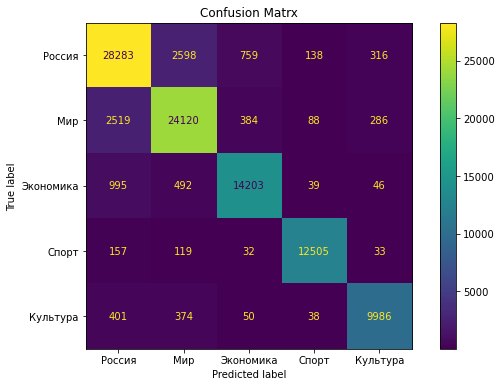

In [16]:
# нарисуем Confusion Matrix, чтобы посмотреть, какие темы модель чаще всего путает
fig, ax = plt.subplots(figsize = (10, 6))
ax.set_title('Confusion Matrix')
class_names = ['Россия', 'Мир', 'Экономика', 'Спорт', 'Культура']

disp = metrics.plot_confusion_matrix(lm, X_test, y_test, ax = ax, display_labels = class_names)
disp.confusion_matrix

Большая часть ошибок случается на пересечении тем "Россия" и "Мир". 

In [3]:
# теперь применим модель TF-IDF с логистической регрессией
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

In [4]:
tfidf_model = TfidfVectorizer(tokenizer = casual_tokenize, max_features = 2000)
tfidf_docs = tfidf_model.fit_transform(raw_documents = df['text_s']).toarray()

In [5]:
X2 = pd.DataFrame(tfidf_docs, index = df.index, columns = tfidf_model.get_feature_names())

In [8]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size = 0.2, random_state = 42)

In [9]:
print(df.shape, X2_train.shape, X2_test.shape)

(494804, 10) (395843, 2000) (98961, 2000)


In [12]:
lm2 = linear_model.LogisticRegression(multi_class = 'ovr', solver = 'liblinear', random_state = 42)
lm2.fit(X2_train, y2_train)
lm2.score(X2_test, y2_test)

0.9006376249229494

In [13]:
predicted_labels = lm2.predict(X2_test)
train_pred = lm2.predict(X2_train)
print('Train Accuracy: ' + str(accuracy_score(y2_train, train_pred)))
print('Train F1-Score(Micro): '+ str(f1_score(y2_train, train_pred, average = 'micro')))
print('------')
print('Test Accuracy: ' + str(accuracy_score(y2_test, predicted_labels)))
print('Test F1-Score(Micro): ' + str(f1_score(y2_test, predicted_labels, average = 'micro')))

Train Accuracy: 0.9034086746513138
Train F1-Score(Micro): 0.9034086746513138
------
Test Accuracy: 0.9006376249229494
Test F1-Score(Micro): 0.9006376249229494


Качество моделей, как в случае преобразования "Мешок слов", так и в случае TF-IDF высокое. Разница между метриками моделей незначительная. 